In [1]:
import tensorflow as tf
import numpy as np
from model import unet
from os import path
import matplotlib.pyplot as plt
from data import *
import pandas as pd
from datetime import datetime
import keras

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
miou = tf.keras.metrics.MeanIoU(num_classes=4)
binmiou = tf.keras.metrics.MeanIoU(num_classes=2)

In [4]:
scce = tf.keras.metrics.SparseCategoricalCrossentropy()
sca = tf.keras.metrics.SparseCategoricalAccuracy()
binsca = tf.keras.metrics.SparseCategoricalAccuracy()

In [5]:
train_df = pd.read_csv('dense-by_date-train-14.csv', index_col=['timestamp', 'num'], parse_dates=['timestamp'])

In [6]:
test_df = pd.read_csv('dense-by_date-test-14.csv', index_col=['timestamp', 'num'], parse_dates=['timestamp'])
# test_df = test_df[test_df.is_dense]

In [7]:
band1_gen, band3_gen, hms_gen, val_band1_gen, val_band3_gen, val_hms_gen = train_data_generator(
    dataframe=test_df,
    batch_size=1, image_side_length=256, seed=None, validation_split_rate=0,
    flip=False,
    shuffle=False,
    classify_level='density'
    )
num_img = len(band1_gen)

Found 27140 non-validated image filenames.
Found 27140 non-validated image filenames.
Found 27140 non-validated image filenames.
Found 0 non-validated image filenames.
Found 0 non-validated image filenames.
Found 0 non-validated image filenames.


In [8]:
scce.reset_states()
sca.reset_states()
miou.reset_states()
binsca.reset_states()
binmiou.reset_states()

In [9]:
model = unet(pretrained_weights="dense-by_date-256-14.hdf5", input_size=(256, 256, 2), classify_level=4)

In [11]:
show_im = False
# break_num = 30
break_num = 219

In [12]:
auto_encoder = False
for i, (bands, targets) in enumerate(stack_gen(band1_gen, band3_gen, hms_gen, auto_encoder=auto_encoder)):
    if i > break_num:
        break
    else:
        # fit
        prediction = model.predict(bands)
        # plot
        prediction_category = prediction.argmax(axis=-1)
        sca.update_state(targets, prediction)
        miou.update_state(targets, prediction_category)
        if show_im:
            fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
            ax[0].imshow(bands[0, :, :, 0], cmap='gray', vmin=0, vmax=1)
            ax[0].set_title("band1")
            ax[1].imshow(bands[0, :, :, 1], cmap='gray', vmin=0, vmax=1)
            ax[1].set_title("band3")
            ax[2].imshow(targets[0, :, :, 0], cmap='gray', vmin=0, vmax=3)
            ax[2].set_title("HMS")
            ax[3].imshow(prediction_category[0], cmap='gray', vmin=0, vmax=3)
            ax[3].set_title("prediction")
            plt.show()

In [13]:
sca.result(), miou.result()

(<tf.Tensor: shape=(), dtype=float32, numpy=0.54100454>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.16445437>)

In [10]:
for i, (bands, targets) in enumerate(stack_gen(band1_gen, band3_gen, hms_gen, auto_encoder=auto_encoder)):
    # fit
    if i > num_img or i > break_num:
        break
# plot
    if auto_encoder:
        prediction4 = model4.predict(bands)
        prediction5 = model5.predict(bands)
        mse_unet.update_state(targets, prediction4)
        mse_fcn.update_state(targets, prediction5)
        if show_im:
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(bands[0, :, :, 0], cmap='gray', vmin=0, vmax=1)
            ax[0].set_title("input (band1)")
            ax[1].imshow(prediction4[0, :, :, 0], cmap='gray', vmin=0, vmax=1)
            ax[1].set_title("auto-encoder U-net")
            ax[2].imshow(prediction5[0, :, :, 0], cmap='gray', vmin=0, vmax=1)
            ax[2].set_title("auto-encoder FCN")
            plt.savefig("example_fig/autoencoderexample{i}.png".format(i=i), dpi=150)
            print("example_fig/autoencoderexample{i}.png".format(i=i))
            plt.show()
    else:
        prediction1 = model1.predict(bands)
        prediction2 = model2.predict(bands)
        prediction3 = model3.predict(bands)
        sca_pre.update_state(targets, prediction1)
        sca_fcn.update_state(targets, prediction2)
        sca_usual.update_state(targets, prediction3)
        if show_im:
            prediction_category1 = prediction1.argmax(axis=-1)
            prediction_category2 = prediction2.argmax(axis=-1)
            prediction_category3 = prediction3.argmax(axis=-1)
            fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
            ax[0].imshow(bands[0, :, :, 0], cmap='gray', vmin=0, vmax=1)
            ax[0].set_title("input (band1)")
            ax[1].imshow(targets[0, :, :, 0], cmap='gray', vmin=0, vmax=3)
            ax[1].set_title("target (HMS)")
            ax[2].imshow(prediction_category1[0], cmap='gray', vmin=0, vmax=3)
            ax[2].set_title("prediction (pre-trained unet)")
            ax[3].imshow(prediction_category2[0], cmap='gray', vmin=0, vmax=3)
            ax[3].set_title("prediction (pre-trained fcn)")
            ax[4].imshow(prediction_category3[0], cmap='gray', vmin=0, vmax=3)
            ax[4].set_title("prediction (pure unet)")
            plt.savefig("example_fig/outputexample{i}.png".format(i=i), dpi=150)
            print("example_fig/outputexample{i}.png".format(i=i))
            plt.show()

In [13]:
sca.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.46505728>

In [ ]:
acclev = [[], [], [], []]
for i, (bands, hms) in enumerate(stack_gen(band1_gen, band3_gen, hms_gen)):
    prediction = model.predict(bands)
    prediction_category = prediction.argmax(axis=-1)
    sca.update_state(hms, prediction_category[0])
    miou.update_state(hms[0, :, :, 0], prediction_category[0])
    binsca.update_state(np.sign(hms), np.sign(prediction_category[0]))
    binmiou.update_state(np.sign(hms[0, :, :, 0]), np.sign(prediction_category[0]))
    for lev in range(4):
        if (hms == lev).sum() > 0:
            acclev[lev].append(np.logical_and((hms[0, :, :, 0] == lev), (prediction_category[0] == lev)).sum() / (hms[0, :, :, 0] == lev).sum())

In [ ]:
for lev in acclev:
    print(np.mean(np.array(lev)))

In [ ]:
sca.result(), miou.result(), binsca.result(), binmiou.result()

In [8]:
filelist = [path.join(hms_path, filename) for filename in listdir(hms_path)]

In [9]:
sumlist = np.empty(len(filelist))
for i, file_path in enumerate(filelist):
    image_array = map_HMS_mask(np.asarray(Image.open(file_path)))
    sumlist[i] = image_array.sum()

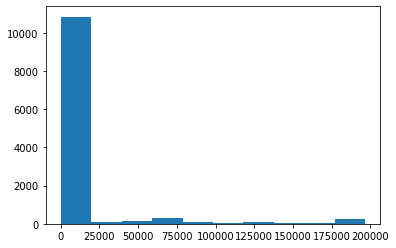

In [11]:
plt.hist(sumlist)
plt.savefig("dist.png", dpi=200)